In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

# import pytorch_ssim

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import os

In [2]:
# from google.colab import files
# from google.colab import drive
# files.upload()
# drive.mount('/content/gdrive')
!unzip train.zip
!unzip val.zip
# !unzip /content/gdrive/MyDrive/data.zip

Archive:  train.zip
replace train/images/test_6235.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  val.zip
replace val/images/val_506.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
# Import custom modules
import process
import loader
import network
from importlib import reload

if torch.cuda.is_available():
    device = 'cuda'
    print("Using GPU")
else:
    device = 'cpu'
    print("Using CPU")

Using CPU


In [5]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
# Transform from [0,255] uint8 to [0,1] float,
# then normalize to zero mean and unit variance

# data loading
train_dir = 'train/images'
val_dir = 'val/images'
train_imgs = loader.image_loader(train_dir, 10000)
val_test_imgs = loader.image_loader(val_dir, 6000)
val_imgs = val_test_imgs[:3000]
test_imgs = val_test_imgs[3000:]

print("Done!")
print(f"Train imgs count: {len(train_imgs)}")
print(f"Val imgs count: {len(val_test_imgs)}")

train_L = process.imgs_tensor(train_imgs)
val_L = process.imgs_tensor(val_imgs)
test_L = process.imgs_tensor(test_imgs)

Loading datasets...
Loading images from train/images...
Loading images from val/images...
Done!
Train imgs count: 10000
Val imgs count: 6000


In [5]:
# Create dataloaders
# Experiment with different batch sizes
batch_size=512
trainloader = DataLoader(train_L, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_L, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_L, batch_size=batch_size, shuffle=True)

In [3]:
# Load model
network = reload(network)
# model = network.Small()
network_channels = [32,64,128]

dropout=0.3
# model = network.Small()
network_channels = [32,64,128]

model = network.Small(
            dropout=dropout, 
            kernel_size=7,
            downscale_by=2,
            batch_norm=True,
            activation=torch.nn.ReLU
        ).to(device)


network_channels = [32,64,128]
model = network.UNet(
        in_channels=1,
        layer_channels=network_channels,
        out_channels=[2,64,128],
        downsample_scale=2,
        kernel_size=3,
        n_convs_per_layer = 2, 
        dropout=0.3
    ).to(device)

1 32
32 32
32 64
64 64
64 128
128 128
192 64 128
64 64 128
96 32 64
32 2 64


In [4]:
import torchvision
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1,1,64,64), expand_nested=True)
model_graph.visual_graph

: 

: 

In [ ]:

network_channels = [32,64,128]
model = network.UNet(
        in_channels=1,
        layer_channels=network_channels,
        out_channels=[2,64,128],
        downsample_scale=2,
        kernel_size=3,
        n_convs_per_layer = 2, 
        dropout=0.3
    ).to(device)

print('Your network:')
# print(summary(model, (1,64,64),device=device)) # visualize your model
criterion = nn.MSELoss() # WE MODIFIED LOSS FUNCTION

# Set up optimization hyperparameters
learning_rate = 1e-3
weight_decay = 5e-5
num_epoch = 50
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=weight_decay)

def train(model, trainloader, valloader, num_epoch=10):  # Train the model
    print("Start training...")
    trn_loss_hist = []
    trn_loss_hist_fine = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()  # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        print(f'-----------------Epoch = {i}/{num_epoch}-----------------')
        for batch, label in tqdm(trainloader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = nn.functional.mse_loss(pred,label) # criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights
            trn_loss_hist_fine.append(loss.item())
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist,trn_loss_hist_fine, trn_acc_hist, val_acc_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    running_acc = []
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            # pred : output ab layer
            # label : original output ab layer
            # batch : L layer
            # Original image : batch + label -> RGB
            # Outputted image : batch + pred -> RGB
            # [512, 1, 64, 64]
            loss = criterion(pred, label)  # Calculate the loss
            running_acc.append(loss.item())
        acc = np.mean(running_acc)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist,fine_trn_losses, trn_acc_hist, val_acc_hist = train(model.to(device), trainloader,
                                                  valloader, num_epoch)


model = model.cpu()

# Note down the evaluation accuracy on test set
print("\n Evaluate on test set")
evaluate(model.to(device), testloader)
model = model.cpu()


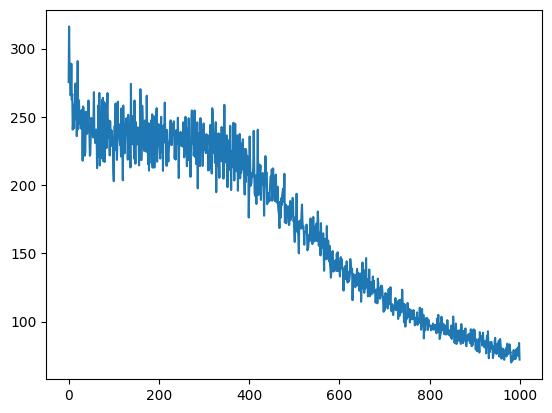

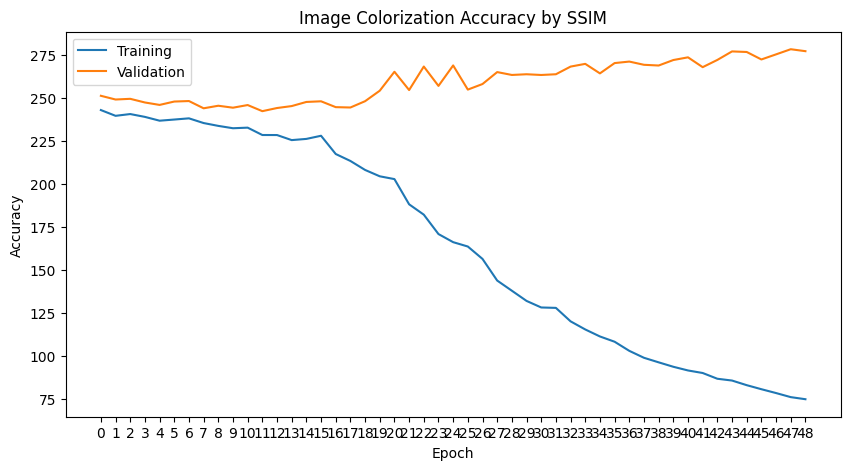

In [86]:

if type(model) is network.UNet: 
    model_name = f'UNet_{learning_rate:1.2e}_epoch_{num_epoch}_dropout_{dropout}_{"_".join(str(ch) for ch in network_channels)}'
else: 
    model_name = f'small_{learning_rate:1.2e}_epoch_{num_epoch}_dropout_{dropout}'

os.makedirs('model_saves',exist_ok=True)
torch.save(model,f'model_saves/{model_name}.pt')
# Submit the accuracy plot

# Submit the accuracy plot
# visualize the training / validation accuracies
plt.figure()
plt.plot(fine_trn_losses)
plt.plot()


x = np.arange(num_epoch -1)
plt.figure()
plt.plot(x, trn_acc_hist[1:])
plt.plot(x, val_acc_hist[1:])
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Image Colorization Accuracy by SSIM')
plt.gcf().set_size_inches(10, 5)
# plt.savefig('part1.png', dpi=300)
plt.show()

In [95]:
model.eval()
# sample = loader.load_img('val/images/val_1009.JPEG')
sample = loader.load_img('val/images/val_1003.JPEG')
def make_comparison(model,img_path,save=True):
  sample = loader.load_img(img_path)
  tens_l_orig, tens_l_rs, ab_vals = process.preprocess_img(sample, HW=(64,64), resample=3)
  tens_l_rs = tens_l_rs# .to(device)


  img_bw = process.postprocess(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
  out_img = process.postprocess(tens_l_orig, model(tens_l_rs).cpu())

  plt.figure(figsize=(10,10))
  plt.subplot(1,3,1)
  plt.imshow(sample)
  plt.title('Original')
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(img_bw)
  plt.title('Input')
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(out_img)
  plt.title('Output Colorized')
  plt.axis('off')
  if save: 
    os.makedirs('figures_out',exist_ok=True)
    plt.savefig(f'figures_out/imgs_{img_path.split("/")[-1]}_{model_name}.jpg')

  plt.show()

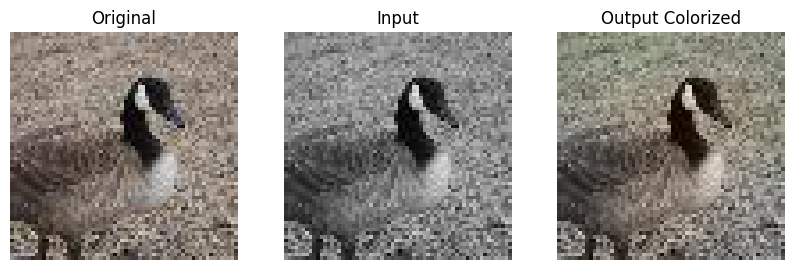

In [96]:
make_comparison(model,'val/images/val_1009.JPEG')

6981


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


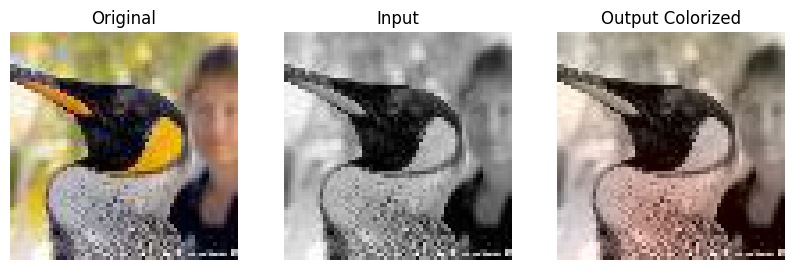

7540


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


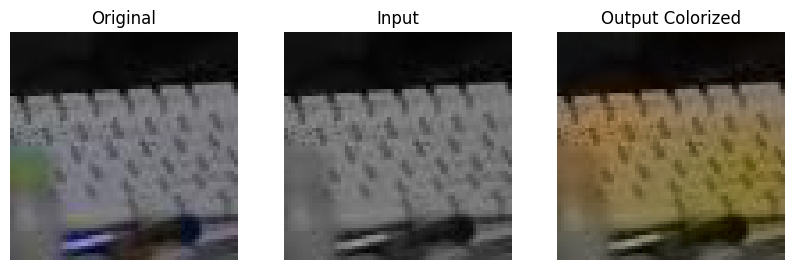

2490


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


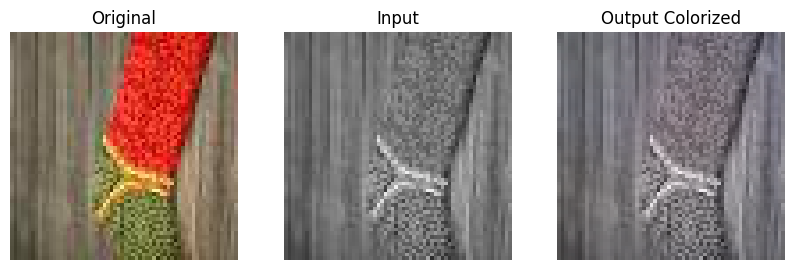

2451


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


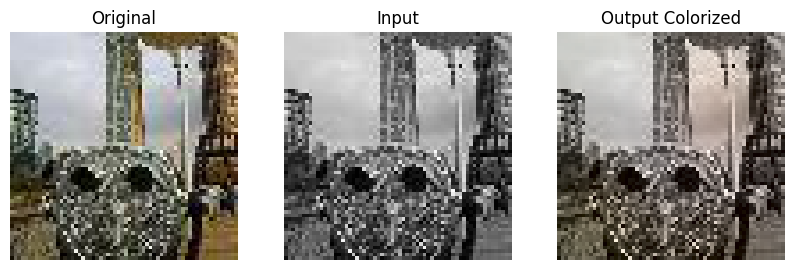

658


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


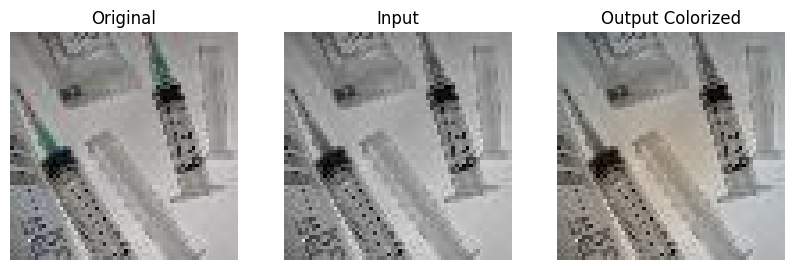

3787


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


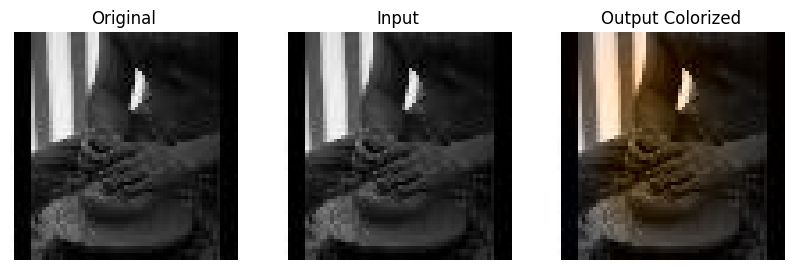

3933


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


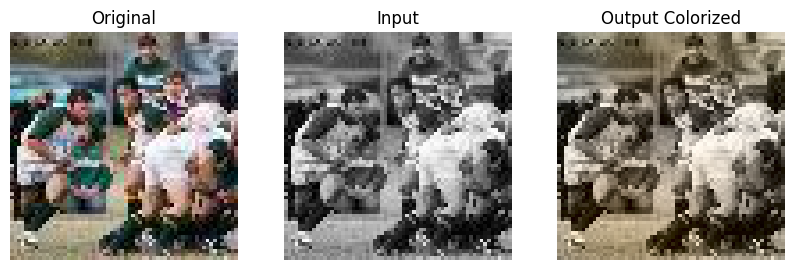

5436


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


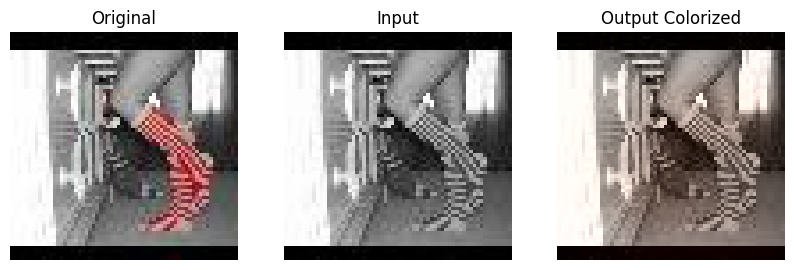

2459


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


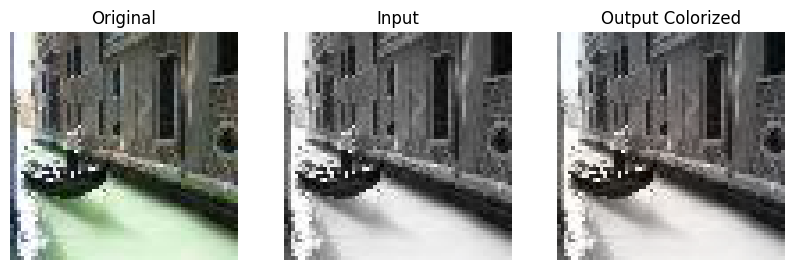

7120


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


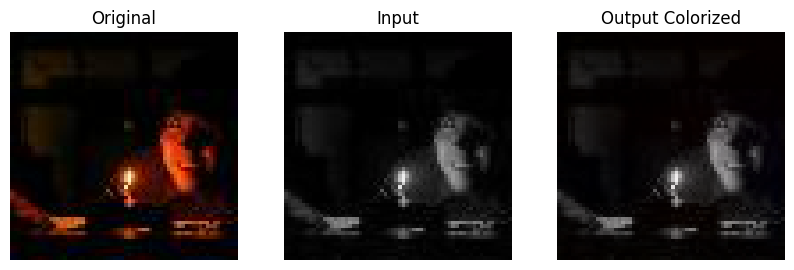

In [97]:
np.random.seed(46)
for i in range(10): 
  img_num = np.random.randint(0,10000)
  print(img_num)
  make_comparison(model,f'val/images/val_{img_num}.JPEG')

In [51]:
vals = model(tens_l_rs).cpu()[0]
print(vals[0,:,:].min(),vals[0,:,:].max())
print(vals[1,:,:].min(),vals[1,:,:].max())


tensor(-11.2691, grad_fn=<MinBackward1>) tensor(4.2036, grad_fn=<MaxBackward1>)
tensor(5.1365, grad_fn=<MinBackward1>) tensor(14.7673, grad_fn=<MaxBackward1>)


In [29]:
!ls train/images

test_0.JPEG	test_2800.JPEG	test_4600.JPEG	test_6400.JPEG	test_8200.JPEG
test_1000.JPEG	test_2801.JPEG	test_4601.JPEG	test_6401.JPEG	test_8201.JPEG
test_1001.JPEG	test_2802.JPEG	test_4602.JPEG	test_6402.JPEG	test_8202.JPEG
test_1002.JPEG	test_2803.JPEG	test_4603.JPEG	test_6403.JPEG	test_8203.JPEG
test_1003.JPEG	test_2804.JPEG	test_4604.JPEG	test_6404.JPEG	test_8204.JPEG
test_1004.JPEG	test_2805.JPEG	test_4605.JPEG	test_6405.JPEG	test_8205.JPEG
test_1005.JPEG	test_2806.JPEG	test_4606.JPEG	test_6406.JPEG	test_8206.JPEG
test_1006.JPEG	test_2807.JPEG	test_4607.JPEG	test_6407.JPEG	test_8207.JPEG
test_1007.JPEG	test_2808.JPEG	test_4608.JPEG	test_6408.JPEG	test_8208.JPEG
test_1008.JPEG	test_2809.JPEG	test_4609.JPEG	test_6409.JPEG	test_8209.JPEG
test_1009.JPEG	test_280.JPEG	test_460.JPEG	test_640.JPEG	test_820.JPEG
test_100.JPEG	test_2810.JPEG	test_4610.JPEG	test_6410.JPEG	test_8210.JPEG
test_1010.JPEG	test_2811.JPEG	test_4611.JPEG	test_6411.JPEG	test_8211.JPEG
test_1011.JPEG	test_2812.JPEG	tes

In [75]:
np.random.get_state()

('MT19937',
 array([3688828073, 3437834860,  314754974, 2805456110,  330148035,
         989329714, 1746564833, 1507081802, 1011502523, 1793526965,
        1227272621, 1704222394, 2869979321, 1050688306, 4151926402,
        1256928194, 1913233096,  408803800, 1759402197,   76658463,
         492267929, 1456852880,  328260075,  357611801,   25533524,
        1731775722,  723331094,  395804270, 2924518094, 2754030773,
        3311857693, 3726350181, 3417200920, 2603131130, 1766837907,
        3178436650, 2580624680, 1646039438, 2954361196, 4041165846,
         431009537,  123967153,  148716289, 1234311996, 1798456204,
        2054860479, 1004289136, 4215115843,  405222694, 3566354327,
        2503659697, 3692900292, 1112056465,  205200638,  335140610,
        1728323354, 3314079310, 1585529604,  930432510, 1226738791,
        1145803458, 3537480907,  498640963, 3232542546, 1499078011,
         784898458, 2205435135, 2568467737,  186383605, 4005101739,
        2469770958, 2036605178,  597